<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#RMSE" data-toc-modified-id="RMSE-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>RMSE</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Градиентный-бустинг-с-CatBoost" data-toc-modified-id="Градиентный-бустинг-с-CatBoost-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Градиентный бустинг с CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.spatial import distance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder



Константы

In [2]:
RANDOM_STATE = 12345

Скрытие предупреждений

In [3]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

Прочитаем данные

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.index.is_monotonic

True

In [6]:
#data.sort_index(inplace=True)

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


У нас таблица с количество заказов (столбец num_orders) без пропусков. Число заказов от 0 до 119 за 10 минут, а по заданию должно быть за час.

In [11]:
data = data.resample('1H').sum()
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В час у нас наблюдается от 0 до 462 машин, в среднем 84, медиана 78. Да, без предсказаний не обойтись.

## Анализ

У нас срез данных с начала марта 2018 года по конец августа 2018.

<AxesSubplot:xlabel='datetime'>

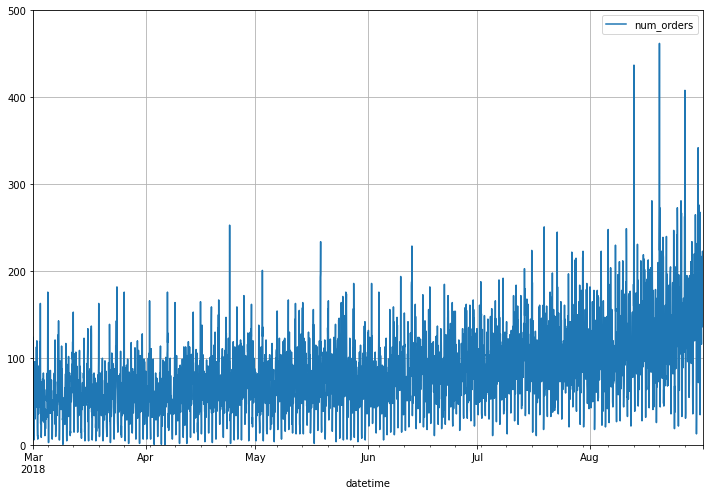

In [12]:
data.plot(ylim=(0, 500), grid=True, figsize = (12,8 ))
#plt.title('график заказов машин в час')

In [13]:
data['rolling_mean'] = data.rolling(24).mean()

<AxesSubplot:title={'center':'график заказов машин в час'}, xlabel='datetime'>

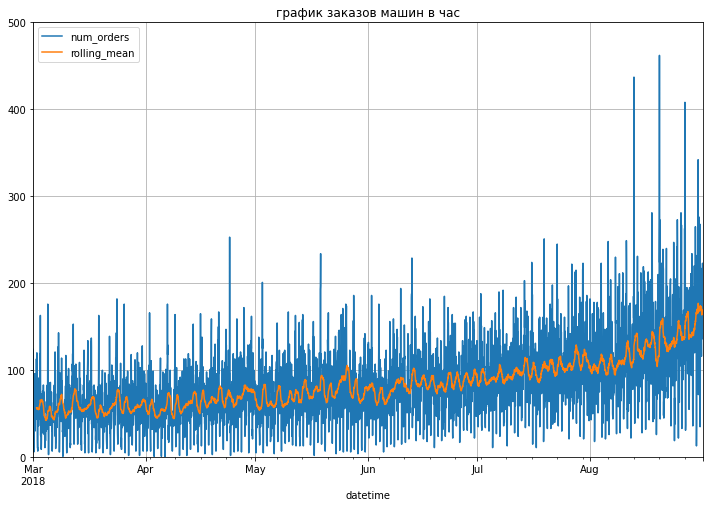

In [14]:
data.plot(ylim=(0, 500), grid=True, figsize = (12,8 ), title ='график заказов машин в час')


График за часа, исправила. График с ресемплингом по дням ниже

,num_orders,rolling_mean
datetime,,
2018-03-01,"AxesSubplot(0.125,0.125;0.775x0.755)","AxesSubplot(0.125,0.125;0.775x0.755)"
2018-03-02,"AxesSubplot(0.125,0.125;0.775x0.755)","AxesSubplot(0.125,0.125;0.775x0.755)"
2018-03-03,"AxesSubplot(0.125,0.125;0.775x0.755)","AxesSubplot(0.125,0.125;0.775x0.755)"
2018-03-04,"AxesSubplot(0.125,0.125;0.775x0.755)","AxesSubplot(0.125,0.125;0.775x0.755)"
2018-03-05,"AxesSubplot(0.125,0.125;0.775x0.755)","AxesSubplot(0.125,0.125;0.775x0.755)"
...,...,...
2018-08-27,"AxesSubplot(0.125,0.125;0.775x0.755)","AxesSubplot(0.125,0.125;0.775x0.755)"
2018-08-28,"AxesSubplot(0.125,0.125;0.775x0.755)","AxesSubplot(0.125,0.125;0.775x0.755)"
2018-08-29,"AxesSubplot(0.125,0.125;0.775x0.755)","AxesSubplot(0.125,0.125;0.775x0.755)"


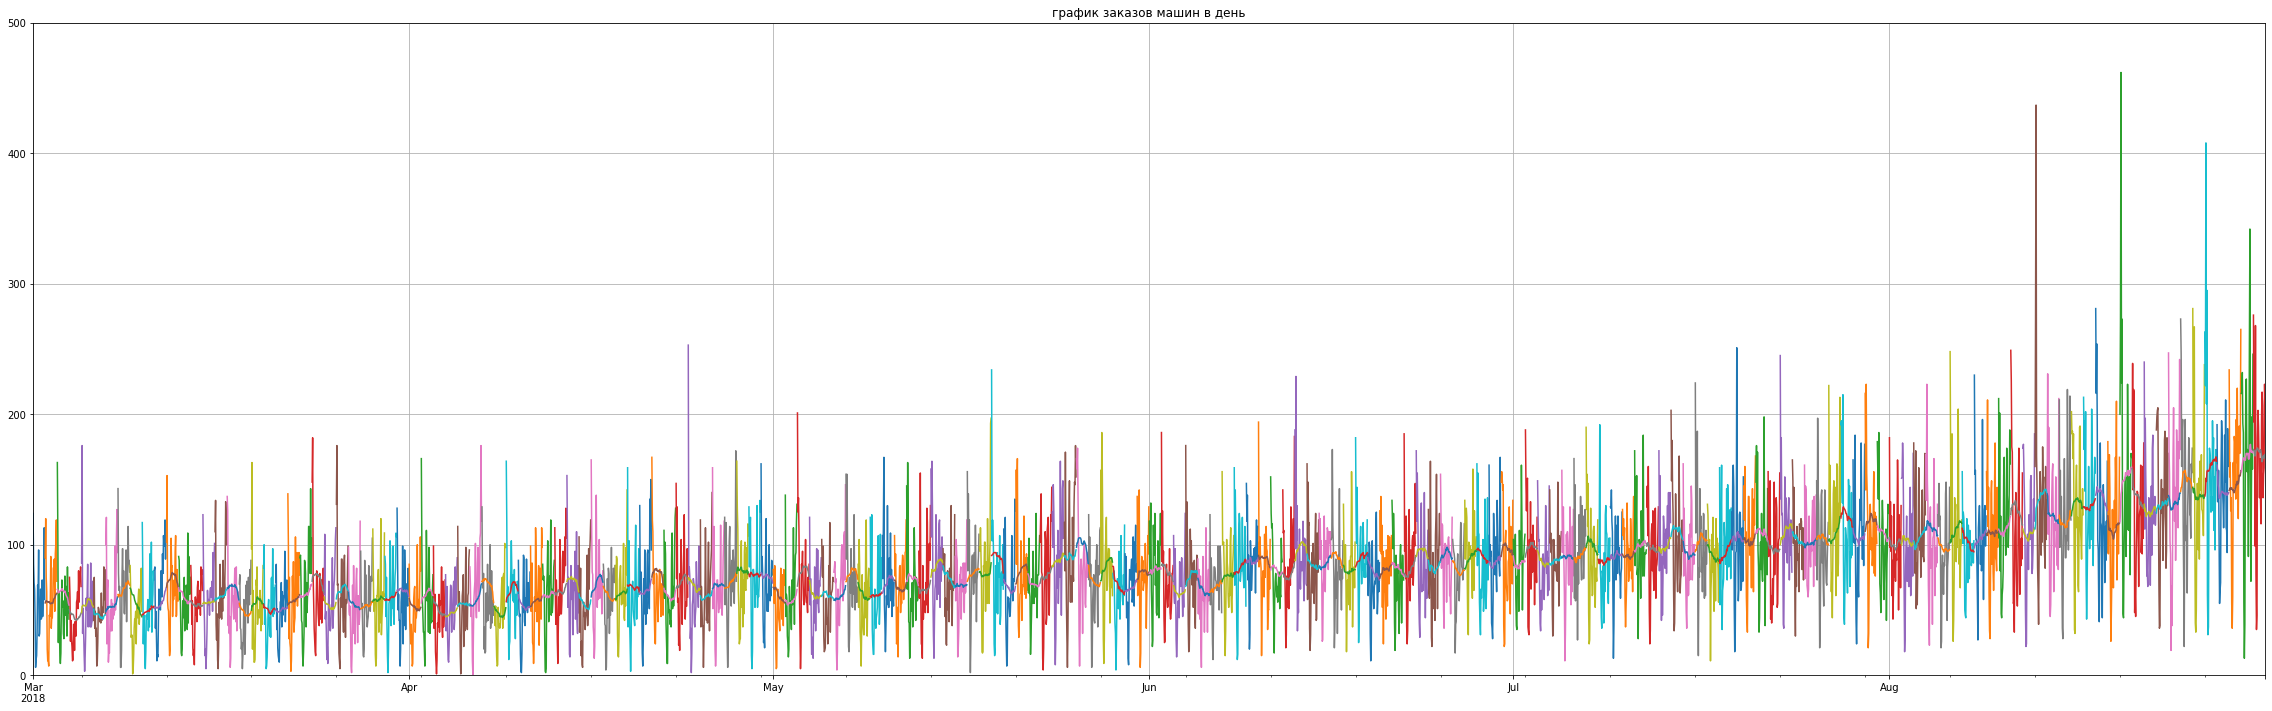

In [15]:
data.resample('1D').plot(ylim=(0, 500), grid=True, figsize = (40,12 ), title ='график заказов машин в день')

 График - иллюстрация к выражению "день на день не приходится"

Хм, мелковато, посмотрим за апрель:

<AxesSubplot:title={'center':'график заказов машин в час за апрель'}, xlabel='datetime'>

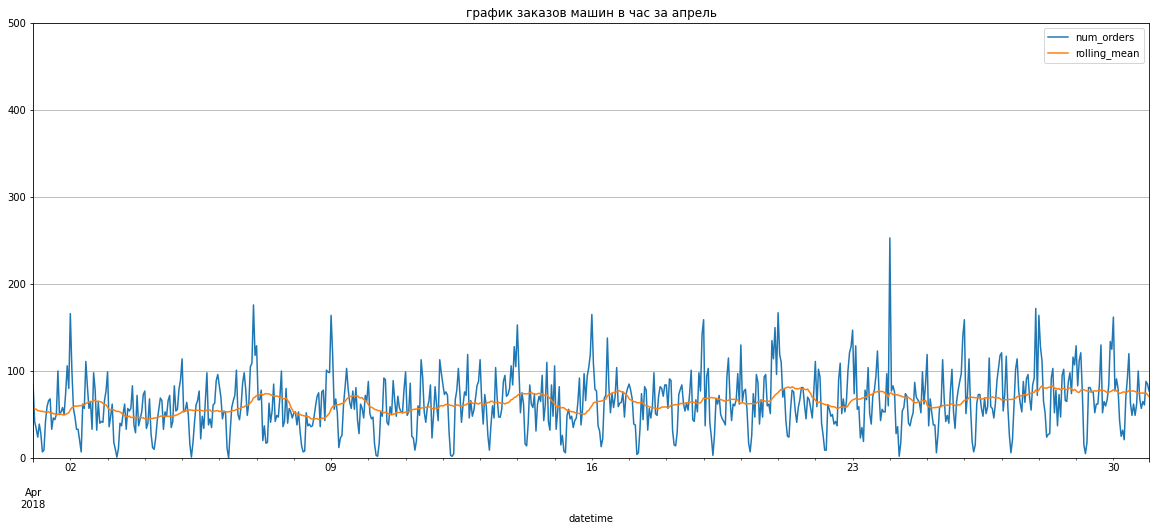

In [16]:
data['2018-04-01':'2018-04-30'].plot(ylim=(0, 500), grid=True, figsize = (20,8 ), title ='график заказов машин в час за апрель')

Явно прослеживаются регулярные всплески и спады. Посмотрим сезонность:

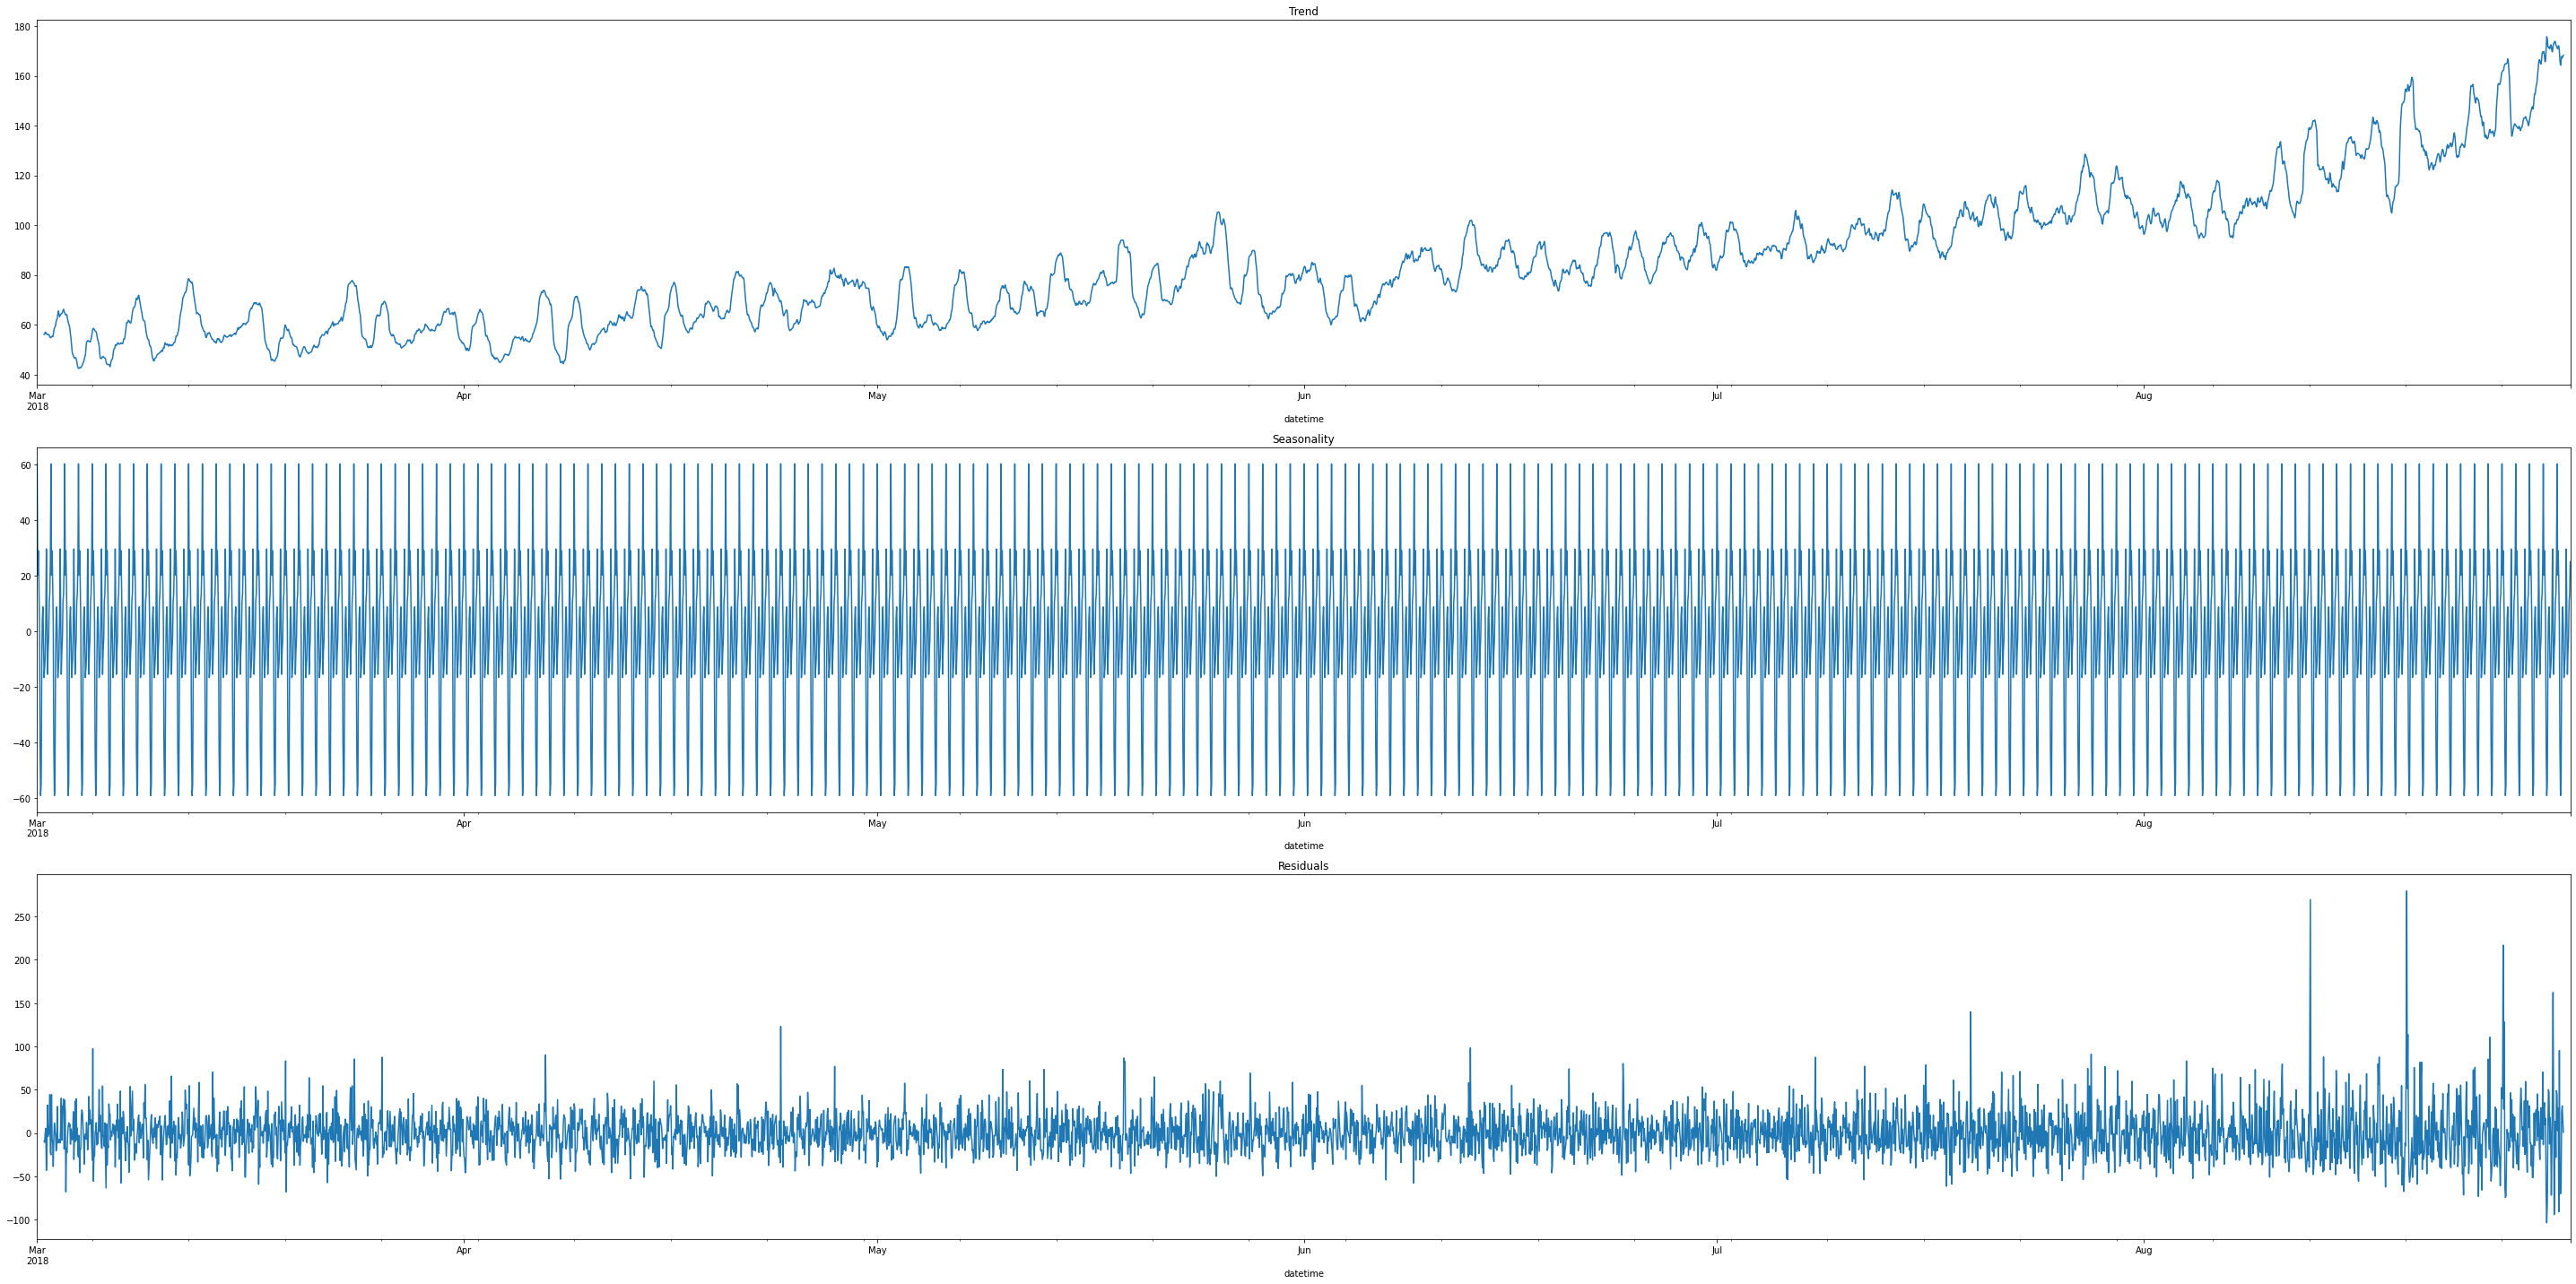

In [17]:
decomposed = seasonal_decompose(data['num_orders']) 

plt.figure(figsize=(40, 20))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Правильная декомпозиция

Снова информация не воспринимается за весь период, смотрим апрель:

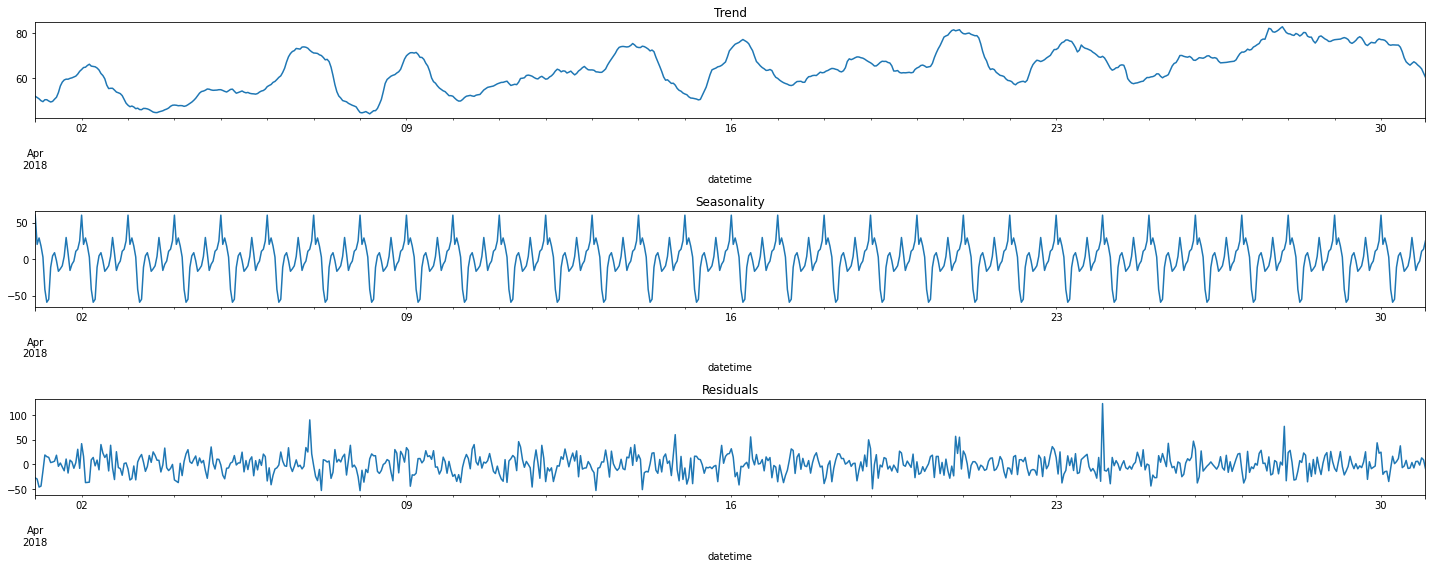

In [18]:

plt.figure(figsize=(20, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend['2018-04-01':'2018-04-30'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-30'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-04-01':'2018-04-30'].plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Разности ряда

<AxesSubplot:xlabel='datetime'>

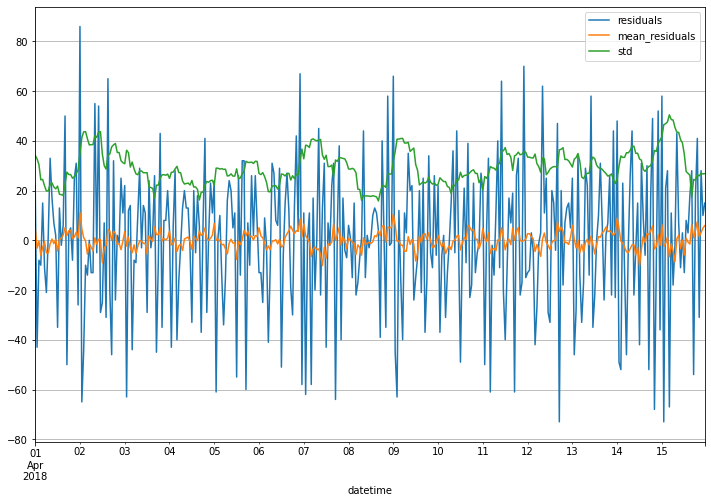

In [19]:
data['residuals'] = data['num_orders'] - data['num_orders'].shift()
data['mean_residuals'] = data['residuals'].rolling(12).mean()
data['std'] = data['residuals'].rolling(12).std()

data[['residuals','mean_residuals', 'std'] ]['2018-04-01':'2018-04-15'].plot(grid=True, figsize = (12,8 ))


Разности дают нелинейную картину, что, в общем, ожидаемо. Колебания в течение суток, колебания по дням недели.

Дополнительно посмотрим сезонность в течение дня. На графике выше как раз видна сезонность по дням - за апрель. Видны ежедневные пики и спады. 

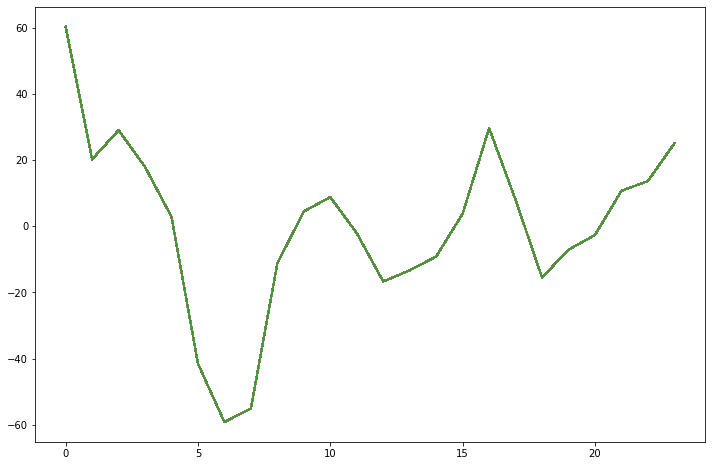

In [20]:


fig = plt.figure(figsize=(12, 8))
counter = 24
while counter < decomposed.seasonal.shape[0]:
    plt.plot(decomposed.seasonal[counter-24:counter].reset_index(drop=True), figure=fig)
    counter += 24

   

На графике видим, что спрос на такси возрастает в конце дня, а затем падает в ранние утреннние часы.

## Создание признаков

<div class="alert alert-info"> <b>Комментарий студента:</b> В соответствии со справедливым замечанием выше перед дальнейшей подготовкой данных - убираем лишнее. Убираем формирование лишних признаков - `year`, `month`. Признак `day` оставляем, вдруг у нас больше заказов в пятницу тринадцатое. Также чистим признаки после анализа: `residuals`, `mean_residuals`, `std`</div></font>

In [21]:
data.columns

Index(['num_orders', 'rolling_mean', 'residuals', 'mean_residuals', 'std'], dtype='object')

In [22]:
data = data.drop(['residuals', 'mean_residuals', 'std'], axis=1) #'residuals'

In [23]:
def make_features(data, max_lag, rolling_mean_size):
#    data['year'] = data.index.year
#    data['month'] = data.index.month
#    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()




    
Не все признаки подойдут:
* `year` - константный признак, ведь данные у нас только за год
* `month` - месяца у нас не повторяются, т.к. данные меньше, чем за год. Тренд отслеживается и без этого признака

Можно при желании также удалить:
* `day` - на самом деле нам достаточно `dayofweek`
    
Ещё в датасете остались признаки после анализа:
* `residuals`
* `mean_residuals`	
* `std`

Есть ли в них потребность? Могут ли появится проблемы при их использовании?

Потребность в дополнительных улучшающих признаках есть всегда, но в случае с разностями - налицо утечка.

In [24]:
make_features(data, 28, 7)



In [25]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()


print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())


features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']


2018-03-02 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Качество прогноза прогнозной константой

In [26]:
print("Среднее число заказов в час:", test['num_orders'].mean())

pred_median = np.ones(test.shape) * train['num_orders'].median()
print("MAE:", mean_absolute_error(test, pred_median))
print("RMSE, прогнозная константа:", mean_squared_error(test, pred_median)**2)

Среднее число заказов в час: 139.55656108597285
MAE: 69.68887753612611
RMSE, прогнозная константа: 54611985.19825873


Ошибка таким методом слишком велика, перейдем к предыдущим значениям ряда:

Качество прогноза предыдущим значением ряда

In [27]:
print("Среднее число заказов в час:", test['num_orders'].mean())

pred_previous = test.shift(fill_value = 0) 
pred_previous.iloc[0]= train['num_orders'][-1]
print("MAE:", mean_absolute_error(test, pred_previous)) 
print("RMSE, предыдущее значение ряда:", mean_squared_error(test, pred_previous)**2)

Среднее число заказов в час: 139.55656108597285
MAE: 42.54292386929957
RMSE, предыдущее значение ряда: 10943434.557840774


Итак, результат предыдущего часа позволяет уже сильно сократить MAE. Очень интересно, что получится по результатам работы моделей.

<div class="alert alert-info"> <b>Комментарий студента:</b> Добавила RMSE для обоих расчётов </div>

## RMSE

In [28]:
from sklearn.metrics import make_scorer

def rmse(target, predictions):
    error = (target - predictions) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

## Обучение

### Дерево решений

In [29]:
best_model = None
best_cross = 10000
best_depth = 0
for depth in range(1, 5): # Проверялись различные диапазоны, выводы ниже.
    model_tr =  DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth) # инициализируйте модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model_tr.fit(features_train, target_train) 
    predictions_train = model_tr.predict(features_train) 
    cross = cross_val_score(model_tr, features_train, target_train, cv=5, scoring = rmse_scorer)
    if cross.mean()< best_cross:
        best_model = model_tr
        best_cross_tr = cross.mean()
        best_depth = depth

print("RMSE наилучшей модели на обучающей выборке:", -best_cross_tr, "Глубина дерева:", best_depth)

RMSE наилучшей модели на обучающей выборке: 28.725202324658504 Глубина дерева: 4


RMSE наилучшей модели на обучающей выборке: 32.59809503951256 Глубина дерева: 4

In [30]:
model_tr =  DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=best_depth)
model_tr.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=4, random_state=12345)

In [31]:
predictions_train = model_tr.predict(features_train)

In [32]:
result_tr = rmse(target_train, predictions_train)
result_tr

26.384160448064435

### Случайный лес

In [33]:
best_model = None
best_est = 0 
best_depth = 0 
best_cross = -25000
best_split = 0
best_leaf = 0
for est in range(27, 28): #был диапазон (1, 30), сокращён до близкого к лучшим значениям
    for depth in range(10,12): #был диапазон (1, 12), сокращён до близкого к лучшим значениям
        for split in range(1,2): #был диапазон (1, 5)
            for leaf in range(1,2): #был диапазон (1, 10)
                model_f = RandomForestRegressor(n_estimators=est, 
                                                max_depth=depth, 
                                                random_state=RANDOM_STATE,  
                                                min_samples_split=split/10,
                                                min_samples_leaf=leaf) 
                model_f.fit(features_train, target_train)
                prediction_f = model_f.predict(features_train)
                cross_rfr = cross_val_score(model_f, features_train, target_train, cv=5, scoring = rmse_scorer) 
                if  cross_rfr.mean()> best_cross:
                    best_est = est
                    best_depth = depth
                    best_cross_rfr = cross_rfr.mean()
                    best_split = split
                    best_leaf = leaf
                    best_model = model_f
                    print(cross_rfr.mean(), est, depth, split, leaf)
print(best_cross_rfr, 'Лучшие гиперпараметры:', best_est,  best_depth, best_split, best_leaf)


-27.19380027598504 27 10 1 1
-27.19380027598504 27 11 1 1
-27.19380027598504 Лучшие гиперпараметры: 27 11 1 1


Получены лучшие гиперпараметры модели случайный лес: 27 11 1 1

In [34]:
model_rfr = RandomForestRegressor(n_estimators=27,  max_depth=11,  random_state=RANDOM_STATE )
model_rfr.fit(features_train, target_train)

RandomForestRegressor(max_depth=11, n_estimators=27, random_state=12345)

In [35]:
predictions_rfr = model_rfr.predict(features_train)
rmse_rfr = rmse(target_train, predictions_rfr)
rmse_rfr

13.231892455152883

И у нас новый лидер - модель случайный лес с RMSE 20.68. 

### Линейная регрессия

Двигаемся дальше, следующая у нас по плану - линейная регрессия. Сперва- классика:

In [36]:
model_l = LinearRegression()

In [37]:
model_l.fit(features_train, target_train) # обучим модель на тренировочной выборке


LinearRegression()

In [38]:
predictions_train_l = model_l.predict(features_train) # получим предсказания модели на тренировочной выборке
cross_l = cross_val_score(model_l, features_train, target_train, cv=5, scoring = rmse_scorer) 

print("RMSE, кросс-валидация:", -cross_l.mean())


RMSE, кросс-валидация: 25.685793080261174


Весьма маленькое число. Посмотрим другой метод для сравнения.

Наш прежний лидер сдался. Линейная регрессия дает RMSE 31.69. Я проверила, что же давало настолько малые числа RMSE в наборе признаков из предыдущей редакции (7.506848856527991e-14). Это как раз разности, столбец residuals. <b>Важный вопрос </b> У нас идет утечка только последнего значения train, можно ли этим пренебречь ради такой точности модели? В текущей редации расчёт без этого столбца. 

### Градиентный бустинг с CatBoost

Не уверена,что он сюда подходит

In [39]:
model_cat = CatBoostRegressor(random_state=RANDOM_STATE,  loss_function="RMSE", iterations=300)
model_cat.fit(features_train, target_train,verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.135355
0:	learn: 36.4446248	total: 57ms	remaining: 17s
10:	learn: 26.2822676	total: 129ms	remaining: 3.39s
20:	learn: 23.9712467	total: 201ms	remaining: 2.67s
30:	learn: 23.0976934	total: 268ms	remaining: 2.33s
40:	learn: 22.2504166	total: 338ms	remaining: 2.13s
50:	learn: 21.7119311	total: 408ms	remaining: 1.99s
60:	learn: 21.0830238	total: 478ms	remaining: 1.87s
70:	learn: 20.5086123	total: 547ms	remaining: 1.76s
80:	learn: 19.8507065	total: 614ms	remaining: 1.66s
90:	learn: 19.3112232	total: 691ms	remaining: 1.58s
100:	learn: 18.7705635	total: 772ms	remaining: 1.52s
110:	learn: 18.2893580	total: 855ms	remaining: 1.46s
120:	learn: 17.8581621	total: 925ms	remaining: 1.37s
130:	learn: 17.4572058	total: 994ms	remaining: 1.28s
140:	learn: 17.0537358	total: 1.06s	remaining: 1.2s
150:	learn: 16.6674880	total: 1.13s	remaining: 1.12s
160:	learn: 16.2356359	total: 1.23s	remaining: 1.06s
170:	learn: 15.8700930	total: 1.31s	remaining: 988ms
180:	learn: 15.5552190	total: 1

In [40]:
predictions_cat_train = model_cat.predict(features_train)
rmse_cat_train = rmse(target_train, predictions_cat_train)
cross_cat = cross_val_score(model_cat, features_train, target_train, cv=5, scoring = rmse_scorer) 

print("RMSE, кросс-валидация c CatBoost на обучении:", -cross_cat.mean())


Learning rate set to 0.13066
0:	learn: 36.9088011	total: 8.24ms	remaining: 2.46s
1:	learn: 35.0831191	total: 15.4ms	remaining: 2.29s
2:	learn: 33.7408159	total: 25.8ms	remaining: 2.55s
3:	learn: 32.4219265	total: 36.4ms	remaining: 2.69s
4:	learn: 31.3562661	total: 43.8ms	remaining: 2.58s
5:	learn: 30.5478935	total: 50.8ms	remaining: 2.49s
6:	learn: 29.7302272	total: 57.8ms	remaining: 2.42s
7:	learn: 28.9985364	total: 64.6ms	remaining: 2.36s
8:	learn: 28.3905505	total: 71.2ms	remaining: 2.3s
9:	learn: 27.8179530	total: 78ms	remaining: 2.26s
10:	learn: 27.4185629	total: 84.5ms	remaining: 2.22s
11:	learn: 27.0531462	total: 90.9ms	remaining: 2.18s
12:	learn: 26.7174961	total: 97.4ms	remaining: 2.15s
13:	learn: 26.3673903	total: 104ms	remaining: 2.13s
14:	learn: 26.1310629	total: 116ms	remaining: 2.2s
15:	learn: 25.9029168	total: 123ms	remaining: 2.19s
16:	learn: 25.6330943	total: 130ms	remaining: 2.17s
17:	learn: 25.3857427	total: 137ms	remaining: 2.15s
18:	learn: 25.1333172	total: 145ms	r

157:	learn: 16.3612954	total: 1.15s	remaining: 1.04s
158:	learn: 16.3064445	total: 1.16s	remaining: 1.03s
159:	learn: 16.2925946	total: 1.17s	remaining: 1.02s
160:	learn: 16.2517253	total: 1.17s	remaining: 1.01s
161:	learn: 16.2307834	total: 1.18s	remaining: 1.01s
162:	learn: 16.2032153	total: 1.19s	remaining: 999ms
163:	learn: 16.1755994	total: 1.2s	remaining: 991ms
164:	learn: 16.1261809	total: 1.2s	remaining: 984ms
165:	learn: 16.0832301	total: 1.21s	remaining: 976ms
166:	learn: 16.0253166	total: 1.22s	remaining: 969ms
167:	learn: 15.9731412	total: 1.22s	remaining: 961ms
168:	learn: 15.9700486	total: 1.23s	remaining: 953ms
169:	learn: 15.9212411	total: 1.24s	remaining: 946ms
170:	learn: 15.8946191	total: 1.24s	remaining: 938ms
171:	learn: 15.8505984	total: 1.25s	remaining: 931ms
172:	learn: 15.8179580	total: 1.26s	remaining: 923ms
173:	learn: 15.7910106	total: 1.26s	remaining: 916ms
174:	learn: 15.7676018	total: 1.27s	remaining: 908ms
175:	learn: 15.7326670	total: 1.28s	remaining: 9

27:	learn: 24.0202386	total: 205ms	remaining: 1.99s
28:	learn: 23.8817489	total: 211ms	remaining: 1.97s
29:	learn: 23.7578244	total: 218ms	remaining: 1.96s
30:	learn: 23.7385292	total: 224ms	remaining: 1.95s
31:	learn: 23.6274867	total: 231ms	remaining: 1.94s
32:	learn: 23.5486496	total: 238ms	remaining: 1.93s
33:	learn: 23.4659576	total: 245ms	remaining: 1.91s
34:	learn: 23.3286086	total: 252ms	remaining: 1.9s
35:	learn: 23.2119207	total: 258ms	remaining: 1.89s
36:	learn: 23.0969681	total: 265ms	remaining: 1.88s
37:	learn: 23.0203832	total: 271ms	remaining: 1.87s
38:	learn: 22.9467828	total: 278ms	remaining: 1.86s
39:	learn: 22.8291928	total: 285ms	remaining: 1.85s
40:	learn: 22.7613743	total: 292ms	remaining: 1.84s
41:	learn: 22.6941709	total: 299ms	remaining: 1.84s
42:	learn: 22.6062739	total: 306ms	remaining: 1.83s
43:	learn: 22.5525409	total: 313ms	remaining: 1.82s
44:	learn: 22.4803502	total: 320ms	remaining: 1.81s
45:	learn: 22.4303603	total: 327ms	remaining: 1.8s
46:	learn: 22.

184:	learn: 15.3187849	total: 1.34s	remaining: 831ms
185:	learn: 15.2769492	total: 1.34s	remaining: 823ms
186:	learn: 15.2364374	total: 1.35s	remaining: 816ms
187:	learn: 15.2337655	total: 1.36s	remaining: 808ms
188:	learn: 15.2000434	total: 1.36s	remaining: 800ms
189:	learn: 15.1704287	total: 1.37s	remaining: 793ms
190:	learn: 15.1424151	total: 1.38s	remaining: 785ms
191:	learn: 15.1111895	total: 1.38s	remaining: 778ms
192:	learn: 15.0711330	total: 1.39s	remaining: 771ms
193:	learn: 15.0454192	total: 1.4s	remaining: 764ms
194:	learn: 14.9894880	total: 1.42s	remaining: 764ms
195:	learn: 14.9427082	total: 1.43s	remaining: 757ms
196:	learn: 14.9347965	total: 1.43s	remaining: 750ms
197:	learn: 14.8956681	total: 1.44s	remaining: 742ms
198:	learn: 14.8807124	total: 1.45s	remaining: 735ms
199:	learn: 14.8787577	total: 1.45s	remaining: 727ms
200:	learn: 14.8676525	total: 1.46s	remaining: 720ms
201:	learn: 14.8457122	total: 1.47s	remaining: 712ms
202:	learn: 14.8028532	total: 1.47s	remaining: 

57:	learn: 21.4832939	total: 427ms	remaining: 1.78s
58:	learn: 21.4398482	total: 434ms	remaining: 1.77s
59:	learn: 21.3672515	total: 441ms	remaining: 1.76s
60:	learn: 21.2870797	total: 448ms	remaining: 1.75s
61:	learn: 21.1722370	total: 456ms	remaining: 1.75s
62:	learn: 21.1353635	total: 462ms	remaining: 1.74s
63:	learn: 21.0518610	total: 470ms	remaining: 1.73s
64:	learn: 20.9526305	total: 481ms	remaining: 1.74s
65:	learn: 20.8957638	total: 492ms	remaining: 1.74s
66:	learn: 20.8180673	total: 503ms	remaining: 1.75s
67:	learn: 20.7593318	total: 511ms	remaining: 1.74s
68:	learn: 20.7377949	total: 522ms	remaining: 1.75s
69:	learn: 20.6535680	total: 533ms	remaining: 1.75s
70:	learn: 20.5625110	total: 544ms	remaining: 1.75s
71:	learn: 20.4786663	total: 555ms	remaining: 1.76s
72:	learn: 20.4306375	total: 567ms	remaining: 1.76s
73:	learn: 20.3924525	total: 578ms	remaining: 1.76s
74:	learn: 20.3076014	total: 588ms	remaining: 1.76s
75:	learn: 20.3005749	total: 600ms	remaining: 1.77s
76:	learn: 2

232:	learn: 13.2647277	total: 1.96s	remaining: 563ms
233:	learn: 13.2317331	total: 1.97s	remaining: 555ms
234:	learn: 13.2107148	total: 1.98s	remaining: 547ms
235:	learn: 13.1744766	total: 1.98s	remaining: 538ms
236:	learn: 13.1371829	total: 1.99s	remaining: 530ms
237:	learn: 13.0981378	total: 2s	remaining: 522ms
238:	learn: 13.0631896	total: 2.01s	remaining: 513ms
239:	learn: 13.0348349	total: 2.02s	remaining: 504ms
240:	learn: 13.0080791	total: 2.02s	remaining: 496ms
241:	learn: 12.9793446	total: 2.03s	remaining: 487ms
242:	learn: 12.9662564	total: 2.04s	remaining: 479ms
243:	learn: 12.9477202	total: 2.05s	remaining: 470ms
244:	learn: 12.9126278	total: 2.05s	remaining: 461ms
245:	learn: 12.8914734	total: 2.06s	remaining: 453ms
246:	learn: 12.8889566	total: 2.07s	remaining: 444ms
247:	learn: 12.8407783	total: 2.08s	remaining: 435ms
248:	learn: 12.8108547	total: 2.08s	remaining: 427ms
249:	learn: 12.7859281	total: 2.09s	remaining: 418ms
250:	learn: 12.7721218	total: 2.1s	remaining: 410

106:	learn: 17.9323890	total: 762ms	remaining: 1.37s
107:	learn: 17.8359699	total: 769ms	remaining: 1.37s
108:	learn: 17.7642463	total: 776ms	remaining: 1.36s
109:	learn: 17.7144060	total: 783ms	remaining: 1.35s
110:	learn: 17.6696366	total: 790ms	remaining: 1.34s
111:	learn: 17.5893885	total: 797ms	remaining: 1.34s
112:	learn: 17.5288756	total: 804ms	remaining: 1.33s
113:	learn: 17.4839480	total: 811ms	remaining: 1.32s
114:	learn: 17.4271612	total: 818ms	remaining: 1.31s
115:	learn: 17.3876303	total: 824ms	remaining: 1.31s
116:	learn: 17.3239426	total: 831ms	remaining: 1.3s
117:	learn: 17.2718340	total: 838ms	remaining: 1.29s
118:	learn: 17.2263831	total: 845ms	remaining: 1.28s
119:	learn: 17.1807185	total: 851ms	remaining: 1.28s
120:	learn: 17.1658254	total: 858ms	remaining: 1.27s
121:	learn: 17.1091266	total: 866ms	remaining: 1.26s
122:	learn: 17.0323338	total: 875ms	remaining: 1.26s
123:	learn: 17.0273027	total: 884ms	remaining: 1.25s
124:	learn: 16.9568298	total: 891ms	remaining: 

266:	learn: 12.0642339	total: 1.9s	remaining: 235ms
267:	learn: 12.0261335	total: 1.91s	remaining: 228ms
268:	learn: 11.9945579	total: 1.92s	remaining: 221ms
269:	learn: 11.9682672	total: 1.93s	remaining: 214ms
270:	learn: 11.9370782	total: 1.94s	remaining: 207ms
271:	learn: 11.9019157	total: 1.94s	remaining: 200ms
272:	learn: 11.8723943	total: 1.95s	remaining: 193ms
273:	learn: 11.8483807	total: 1.96s	remaining: 186ms
274:	learn: 11.8187005	total: 1.97s	remaining: 179ms
275:	learn: 11.7846754	total: 1.97s	remaining: 172ms
276:	learn: 11.7649589	total: 1.98s	remaining: 164ms
277:	learn: 11.7512777	total: 1.99s	remaining: 157ms
278:	learn: 11.7363737	total: 1.99s	remaining: 150ms
279:	learn: 11.7122761	total: 2s	remaining: 143ms
280:	learn: 11.7012195	total: 2.01s	remaining: 136ms
281:	learn: 11.6818418	total: 2.02s	remaining: 129ms
282:	learn: 11.6803907	total: 2.02s	remaining: 121ms
283:	learn: 11.6678817	total: 2.03s	remaining: 114ms
284:	learn: 11.6463796	total: 2.04s	remaining: 107

150:	learn: 14.4702608	total: 950ms	remaining: 938ms
151:	learn: 14.4255632	total: 956ms	remaining: 931ms
152:	learn: 14.3791852	total: 962ms	remaining: 925ms
153:	learn: 14.3767078	total: 969ms	remaining: 918ms
154:	learn: 14.3486228	total: 976ms	remaining: 913ms
155:	learn: 14.3446421	total: 982ms	remaining: 907ms
156:	learn: 14.3121634	total: 988ms	remaining: 900ms
157:	learn: 14.2831059	total: 995ms	remaining: 894ms
158:	learn: 14.2513438	total: 1s	remaining: 888ms
159:	learn: 14.1981697	total: 1.01s	remaining: 881ms
160:	learn: 14.1724028	total: 1.01s	remaining: 875ms
161:	learn: 14.1205019	total: 1.02s	remaining: 869ms
162:	learn: 14.0879369	total: 1.03s	remaining: 863ms
163:	learn: 14.0431782	total: 1.03s	remaining: 857ms
164:	learn: 13.9863564	total: 1.04s	remaining: 850ms
165:	learn: 13.9539722	total: 1.04s	remaining: 844ms
166:	learn: 13.9159458	total: 1.05s	remaining: 838ms
167:	learn: 13.9139122	total: 1.06s	remaining: 831ms
168:	learn: 13.8734849	total: 1.06s	remaining: 82

## Тестирование

При сравнении получается, что линейная регрессия показывает результат намного лучше, чем catboost (что для меня удивительно, раньше выигрывал всегда catboost). MAE градиентного бустинга с CatBoost на обучении: 0.8850114807772644 против MAE: 2.6926579200674078e-14 линейной регрессии. Разница настолько велика, что не колеблясь оставим для теста линейную регрессию

<div class="alert alert-warning">
<b>1 Комментарий ревьюера ⚠️:</b> Иногда более простые модели показывают результаты выше, чем сложные
    

In [41]:
data = {'RMSE на обучении ':[ -best_cross_tr, -best_cross_rfr, -cross_l.mean(), -cross_cat.mean()]} 
# Creates pandas DataFrame. 
plt = pd.DataFrame(data, index =[ 'Дерево решений', 'Случайный лес', 'Линейная регрессия',
                                  'Градиентный бустинг с CatBoost']) 

display(plt)

,RMSE на обучении
Дерево решений,28.725202
Случайный лес,27.193800
Линейная регрессия,25.685793
Градиентный бустинг с CatBoost,23.534110


Наш новый лидер в гонке RMSE - catboost. RMSE - 23.5 </div>

In [42]:
predictions_test_l = model_l.predict(features_test) # получим предсказания модели на тестовой выборке
print("MAE, тест:", mean_absolute_error(target_test, predictions_test_l))
print("RMSE, тест:", rmse(target_test, predictions_test_l))

MAE, тест: 33.31699702184998
RMSE, тест: 45.13512970481691


In [43]:
predictions_cat_test = model_cat.predict(features_test)
rmse_cat_test = rmse(target_test, predictions_cat_test)
print("RMSE градиентного бустинга с CatBoost на тестовой выборке:", rmse_cat_test)



RMSE градиентного бустинга с CatBoost на тестовой выборке: 40.89744451492389


In [44]:
predictions_rfr = model_rfr.predict(features_test)
rmse_rfr = rmse(target_test, predictions_rfr)
rmse_rfr

44.18784446121643

**Вывод** При решении задачи наиболее целесообразно выбрать линейную регрессию как метод, дающий наименьшее значение RMSE на обучающей выборке. На тестовой выборке мы получаем значение МАЕ 1.238314484596677e-53, что меньше 48.

 При решении задачи наиболее целесообразен выбор градиентного бустинга CatBoost  как модель с наименьшим  значением RMSE на обучающей выборке при кросс-валидации. На тестовой выборке мы получаем значение RMSE градиентного бустинга с CatBoost на тестовой выборке: 40.90, что меньше 48. Для снижения RMSE  функции make_features(data, max_lag, rolling_mean_size) мы передавали значения  max_lag - 28, rolling_mean_size - 7.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48